In [1]:
import numpy as np
import torch
from pytorch_rnn import *
from dms_task import *
from utils import *
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

### We first initialize dictionaries to keep track of model, task and training parameters

In [2]:
n_stims = 2  # number of potential stimuli

params = {
    "nonlinearity": "tanh",           # activation function
    "rank": 0,                        # rank, set to 0 for full rank
    "n_inp": n_stims,                 # amount of input units
    "p_inp": 1,                       # probability of connection input
    "n_rec": 100,                     # amount of recurrent units
    "p_rec": 1,                       # probability of connection recurrent
    "n_out": 1,                       # amount of output units
    "scale_w_inp": 1,                 # scale input weights
    "scale_w_out": 1,                 # scale output weights
    "w_rec_dist": "gauss",            # recurrent weight dist, gauss or gamma
    "spectr_rad": 1.5,                # gain param, recurrent weights
    "spectr_norm": True,              # use spectral normalisation on rec weights
    "apply_dale": True,               # only exitatory / inhibitory outgoing conns
    "p_inh": 0.2,                     # probability of inhibitory connection
    "balance_dale": True,             # expected input to units (per model) is 0
    "row_balance_dale": False,        # expected input to units (per unit) is 0
    "1overN_out_scaling": False,      # deep versus shallow learning? (not well tested)
    "train_w_inp": True,              # train input weights
    "train_w_inp_scale": False,       # train input scaling factor
    "train_w_rec": True,              # train recurrent weights
    "train_b_rec": False,             # train recurrent bias
    "train_taus": False,              # train time constants
    "train_w_out": True,              # train output weights
    "train_w_out_scale": False,       # train output scaling factor
    "train_b_out": False,             # train output bias
    "train_x0": True,                 # train initial state
    "tau_lims": [100],                # tau limits (min, max) or (value) in ms
    "dt": 10,                         # timestep in ms
    "noise_std": 0.05,                # noise std
    "scale_x0": 0.1,                  # std of initial state, if gaussian
}

training_params = {
    "n_epochs": 200,                  # number of passes through possible trials
    "lr": 1e-3,                       # learning rate
    "batch_size": 4,                  # batch size
    "clip_gradient": 1,               # to avoid explosion of gradients
    "cuda": True,                     # train on GPU if True
    "loss_fn": "mse",                 # loss function (mse, cos or none)
    "optimizer": "adam",              # optimizer (adam)
    "osc_reg_cost": 0,                # oscillatory regularisation weight
    "osc_reg_freq": 2,                # oscillatory regularisation frequency
}

task_params = {
    "stim_ons": 40,                   # stimulus onset
    "rand_ons": 0,                    # randomise onset with this amount
    "stim_dur": 20,                   # stimulus duration
    "stim_offs": 20,                  # stimulus offsets
    "delay": 100,                     # delay length
    "rand_delay": 0,                  # randomize delay with this amount
    "probe_dur": 20,                  # probe duration
    "probe_offs": 20,                 # probe offset
    "response_dur": 20,               # response duration
    "response_ons": 20,               # response onset
    "seq_len": 1,                     # sequence length
    "n_channels": n_stims,            # number of stimulus
}

### We can then initialize the task and plot an example trial

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


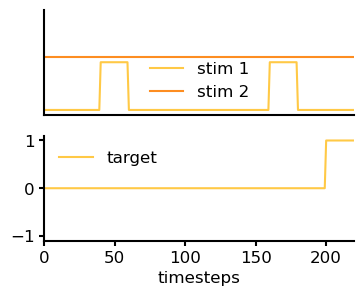

In [3]:
dms = DMS(task_params)

s, t, m = dms[0]

with mpl.rc_context(fname="matplotlibrc"):

    fig, axs = plt.subplots(2, figsize=(4, 3))
    axs[0].plot(s[:, 0], label="stim 1")
    axs[0].plot(s[:, 1] + 1.1, label="stim 2")
    axs[0].set_ylim(-0.1, 2.1)
    axs[0].legend()
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_xlim(0, dms.trial_len())
    axs[1].plot(t, label="target")
    axs[1].legend()
    axs[1].set_ylim(-1.1, 1.1)
    axs[1].set_xlabel("timesteps")
    axs[1].set_xlim(0, dms.trial_len())

### Initialize an RNN and start training it

In [4]:
rnn = RNN(params)

losses, reg_losses = train_rnn(rnn, training_params, dms, sync_wandb=False)

spectral_rad: 1.5
epoch 200 / 200:  task loss=0.001398, reg loss=0.000000, time=21.2 sec.
Done. Training took 21.2 sec.


### Plot the trained weight matrix

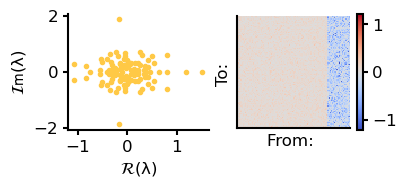

In [5]:
with mpl.rc_context(fname="matplotlibrc"):
    w_eff = rnn.rnn.mask(rnn.rnn.w_rec, rnn.rnn.dale_mask)
    w_eff = w_eff.cpu().detach().numpy()
    eigvals = np.linalg.eigvals(w_eff)
    fig, axs = plt.subplots(1, 2, figsize=(4, 1.5))
    axs[0].scatter(np.real(eigvals), np.imag(eigvals))
    axs[0].set_xlabel(r"$\mathcal{R}(\lambda)$")
    axs[0].set_ylabel(r"$\mathcal{Im}(\lambda)$")
    axs[1].set_ylabel("To: ")
    axs[1].set_xlabel("From: ")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    vmax = np.max(abs(w_eff))
    im = axs[1].imshow(w_eff, vmin=-vmax, vmax=vmax, cmap="coolwarm")
    fig.colorbar(im)

In [6]:
# plot distribution of time constants, if used
if len(params["tau_lims"]) > 1:
    plt.hist(
        Project_taus(rnn.rnn.taus_gaus, rnn.rnn.tau[0], rnn.rnn.tau[1])
        .cpu()
        .detach()
        .numpy()
        .flatten()
    )

### Plot output for an example match and non match trial


test loss: 0.0055001405999064445


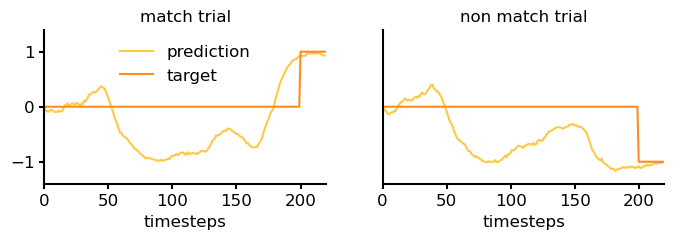

In [7]:
dataloader = DataLoader(dms, batch_size=training_params["batch_size"], shuffle=False)
s, t, m = next(iter(dataloader))
rates, pred = predict(rnn, s, mse_loss, t, m)

with mpl.rc_context(fname="matplotlibrc"):
    fig, axs = plt.subplots(1, 2, figsize=(8, 2))
    axs[0].set_title("match trial")
    axs[0].plot(pred[0], label="prediction")
    axs[0].plot(t[0], label="target")
    axs[0].set_ylim(-1.4, 1.4)
    axs[0].legend()
    axs[0].set_xlim(0, dms.trial_len())
    axs[0].set_xlabel("timesteps")
    axs[1].set_title("non match trial")
    axs[1].set_yticks([])
    axs[1].plot(pred[2], label="prediction")
    axs[1].plot(t[2], label="target")
    axs[1].set_ylim(-1.4, 1.4)
    axs[1].set_xlabel("timesteps")
    axs[1].set_xlim(0, dms.trial_len())

### Plot trajectories projected on first three PCs

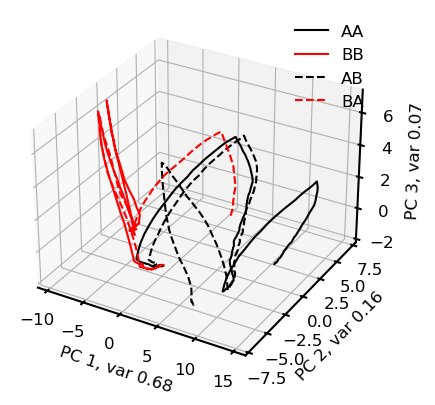

In [8]:
z, varexp = PC_traj(rates, n_comp=3)
with mpl.rc_context(fname="matplotlibrc"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(z[0, :, 0], z[0, :, 1], z[0, :, 2], color="black", label="AA")
    ax.plot(z[1, :, 0], z[1, :, 1], z[1, :, 2], color="red", label="BB")
    ax.plot(z[2, :, 0], z[2, :, 1], z[2, :, 2], color="black", ls="--", label="AB")
    ax.plot(z[3, :, 0], z[3, :, 1], z[3, :, 2], color="red", ls="--", label="BA")
    ax.set_xlabel("PC 1, var {:.2f}".format(varexp[0]))
    ax.set_ylabel("PC 2, var {:.2f}".format(varexp[1]))
    ax.set_zlabel("PC 3, var {:.2f}".format(varexp[2]))
    plt.legend()
    plt.show()

### Save and load a model
We plot the output for the previous two trials to check the loaded model

spectral_rad: 1.5
test loss: 0.003945932723581791


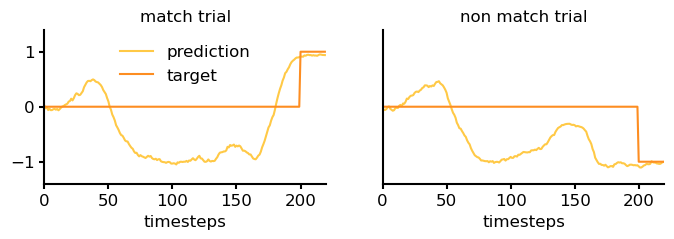

In [9]:
# save and load
save_rnn("test_model", rnn, params, task_params, training_params)
rnn2, params, task_params, training_params = load_rnn("test_model")

# plot example output of new net
rates, pred = predict(rnn2, s, mse_loss, t, m)

with mpl.rc_context(fname="matplotlibrc"):
    fig, axs = plt.subplots(1, 2, figsize=(8, 2))
    axs[0].set_title("match trial")
    axs[0].plot(pred[0], label="prediction")
    axs[0].plot(t[0], label="target")
    axs[0].set_ylim(-1.4, 1.4)
    axs[0].legend()
    axs[0].set_xlim(0, dms.trial_len())
    axs[0].set_xlabel("timesteps")
    axs[1].set_title("non match trial")
    axs[1].set_yticks([])
    axs[1].plot(pred[2], label="prediction")
    axs[1].plot(t[2], label="target")
    axs[1].set_ylim(-1.4, 1.4)
    axs[1].set_xlabel("timesteps")
    axs[1].set_xlim(0, dms.trial_len())

### We can also regularize an RNN to exhibit oscillatory activity

In [10]:
training_params["osc_reg_cost"] = 5
training_params["osc_reg_freq"] = 3

rnn_osc = RNN(params)
losses, reg_losses = train_rnn(rnn_osc, training_params, dms, sync_wandb=False)

spectral_rad: 1.5000001
epoch 200 / 200:  task loss=0.031554, reg loss=0.062116, time=23.8 sec.
Done. Training took 23.8 sec.


In [11]:
rates, pred = predict(rnn_osc, s, mse_loss, t, m)

LFP = (
    extract_lfp(torch.from_numpy(rates).cuda(), rnn.rnn, normalize=False)
    .cpu()
    .detach()
    .numpy()
)

freqs_l = np.logspace(*np.log10([1, 10]), num=50)
dt_sec = params["dt"] / 1000
tm = np.arange(0, dms.trial_len() * dt_sec, dt_sec)
_, amp = scalogram(
    LFP[0],
    7,
    tm,
    dt_sec,
    freqs_l,
)

test loss: 0.04152754694223404


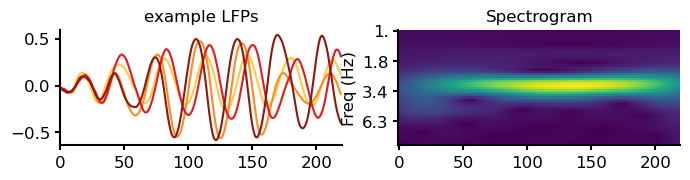

In [12]:
with mpl.rc_context(fname="matplotlibrc"):

    fig, axs = plt.subplots(1, 2, figsize=(8, 1.5))
    axs[0].set_title("example LFPs")
    axs[0].plot(LFP.T)
    axs[0].set_xlim(0, dms.trial_len())

    axs[1].set_title("Spectrogram")
    axs[1].imshow(amp, aspect="auto")
    axs[1].set_yticks(np.arange(0, len(freqs_l))[::13])
    axs[1].set_yticklabels(["{:.1f}".format(f).strip("0") for f in freqs_l[::13]])
    axs[1].set_ylabel("Freq (Hz)")

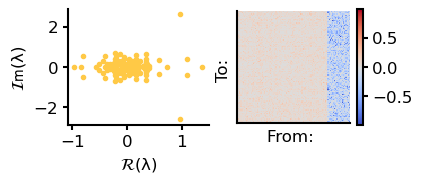

In [13]:
with mpl.rc_context(fname="matplotlibrc"):
    w_eff = rnn_osc.rnn.mask(rnn_osc.rnn.w_rec, rnn_osc.rnn.dale_mask)
    w_eff = w_eff.cpu().detach().numpy()
    eigvals = np.linalg.eigvals(w_eff)
    fig, axs = plt.subplots(1, 2, figsize=(4, 1.5))
    axs[0].scatter(np.real(eigvals), np.imag(eigvals))
    axs[0].set_xlabel(r"$\mathcal{R}(\lambda)$")
    axs[0].set_ylabel(r"$\mathcal{Im}(\lambda)$")
    axs[1].set_ylabel("To: ")
    axs[1].set_xlabel("From: ")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    vmax = np.max(abs(w_eff))
    im = axs[1].imshow(w_eff, vmin=-vmax, vmax=vmax, cmap="coolwarm")
    fig.colorbar(im)